In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from pywt import wavedec
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
data = pd.read_csv('../data/sensor_data.csv')
ecg_signal = data['value'].to_numpy()
data.head()

,id,value,timestamp
0,1,527,2024-12-01 20:24:53
1,2,521,2024-12-01 20:24:53
2,3,522,2024-12-01 20:24:54
3,4,524,2024-12-01 20:24:54
4,5,484,2024-12-01 20:24:54


In [13]:
data['timestamp'] = pd.to_datetime(data['timestamp'])
time = (data['timestamp'] - data['timestamp'].iloc[0]).dt.total_seconds().to_numpy()
data['time_diff'] = data['timestamp'].diff()
umbral = pd.Timedelta(seconds=10)
data_filtrado = data[data['time_diff'] <= umbral]
data_filtrado = data_filtrado.drop(columns=['time_diff'])
data_filtrado = data_filtrado.drop(columns=['id'])
data_filtrado

,value,timestamp
1,521,2024-12-01 20:24:53
2,522,2024-12-01 20:24:54
3,524,2024-12-01 20:24:54
4,484,2024-12-01 20:24:54
5,460,2024-12-01 20:24:55
...,...,...
5563,508,2024-12-01 20:57:42
5564,472,2024-12-01 20:57:42
5565,508,2024-12-01 20:57:42
5566,461,2024-12-01 20:57:43


In [15]:
filtro_pasabajas = butter(4, 0.2, btype="low", fs=1000)  # Orden 4, frecuencia de corte 0.2 Hz
ecg_filtrada = filtfilt(filtro_pasabajas[0], filtro_pasabajas[1], ecg_signal)
ecg_normalizada = (ecg_filtrada - np.min(ecg_filtrada)) / (np.max(ecg_filtrada) - np.min(ecg_filtrada))

In [16]:
coeffs = wavedec(ecg_normalizada, wavelet='haar', level=4)
approximation = coeffs[0]
details = np.concatenate(coeffs[1:])

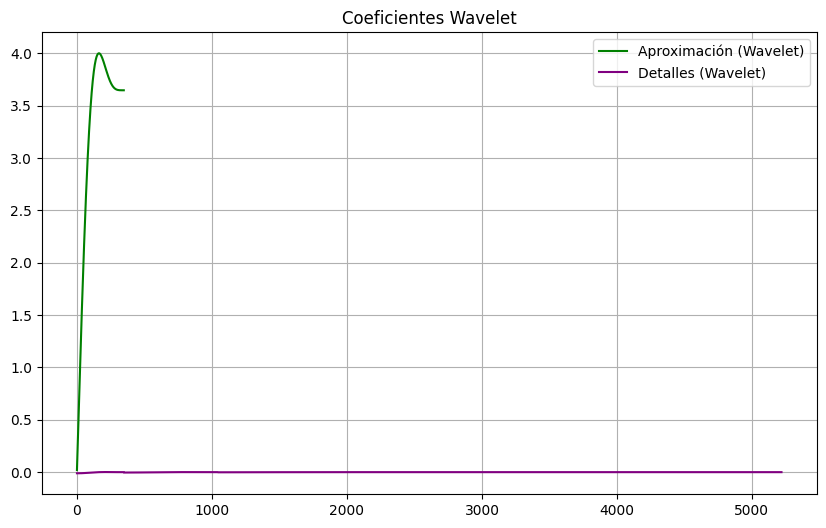

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(approximation, label="Aproximación (Wavelet)", color="green")
plt.plot(details, label="Detalles (Wavelet)", color="purple")
plt.legend()
plt.title("Coeficientes Wavelet")
plt.grid()
plt.show()

In [18]:
X_train = np.reshape(ecg_normalizada, (len(ecg_normalizada), 1))

In [19]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(X_train.shape[1], activation='linear')
])

C:\Users\junit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history = model.fit(X_train, X_train, epochs=50, batch_size=16)

# Paso 6: Predicción (reconstrucción de la señal)
reconstructed = model.predict(X_train)

# Paso 7: Calcular el error de reconstrucción
error = np.mean((X_train - reconstructed) ** 2, axis=1)

# Paso 8: Detectar anomalías (basado en el umbral de error)
threshold = np.mean(error) + 2 * np.std(error)
anomalies = np.where(error > threshold)[0]

Epoch 1/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1666
Epoch 2/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.2226e-06
Epoch 3/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.3571e-06
Epoch 4/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5978e-06
Epoch 5/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0917e-06
Epoch 6/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.7122e-07
Epoch 7/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.1714e-07
Epoch 8/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4070e-07
Epoch 9/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.0253e-07
Epoch 10/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.6288e-07
Epoch 11/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.2268e-07
Epoch 12/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.6123e-07
Epoch 13/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.9056e-07
Epoch 14/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5823e-07
Epoch

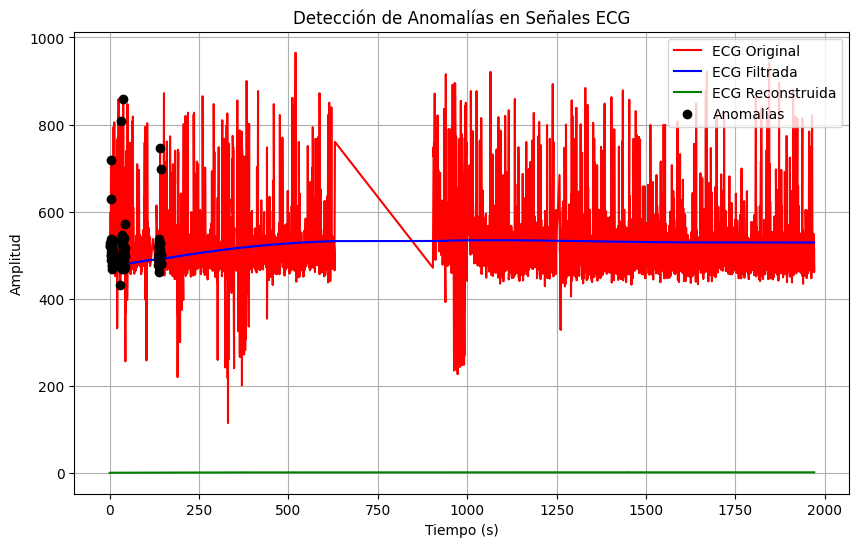

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(time, ecg_signal, label="ECG Original", color="red")
plt.plot(time, ecg_filtrada, label="ECG Filtrada", color="blue")
plt.plot(time, reconstructed.flatten(), label="ECG Reconstruida", color="green")
plt.scatter(time[anomalies], ecg_signal[anomalies], color='black', label='Anomalías', zorder=5)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()
plt.title('Detección de Anomalías en Señales ECG')
plt.grid(True)
plt.show()

In [ ]:
model.save_weights("autoencoder.weights.h5")

C:\Users\junit\AppData\Local\Temp\ipykernel_21548\1006971162.py:50: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


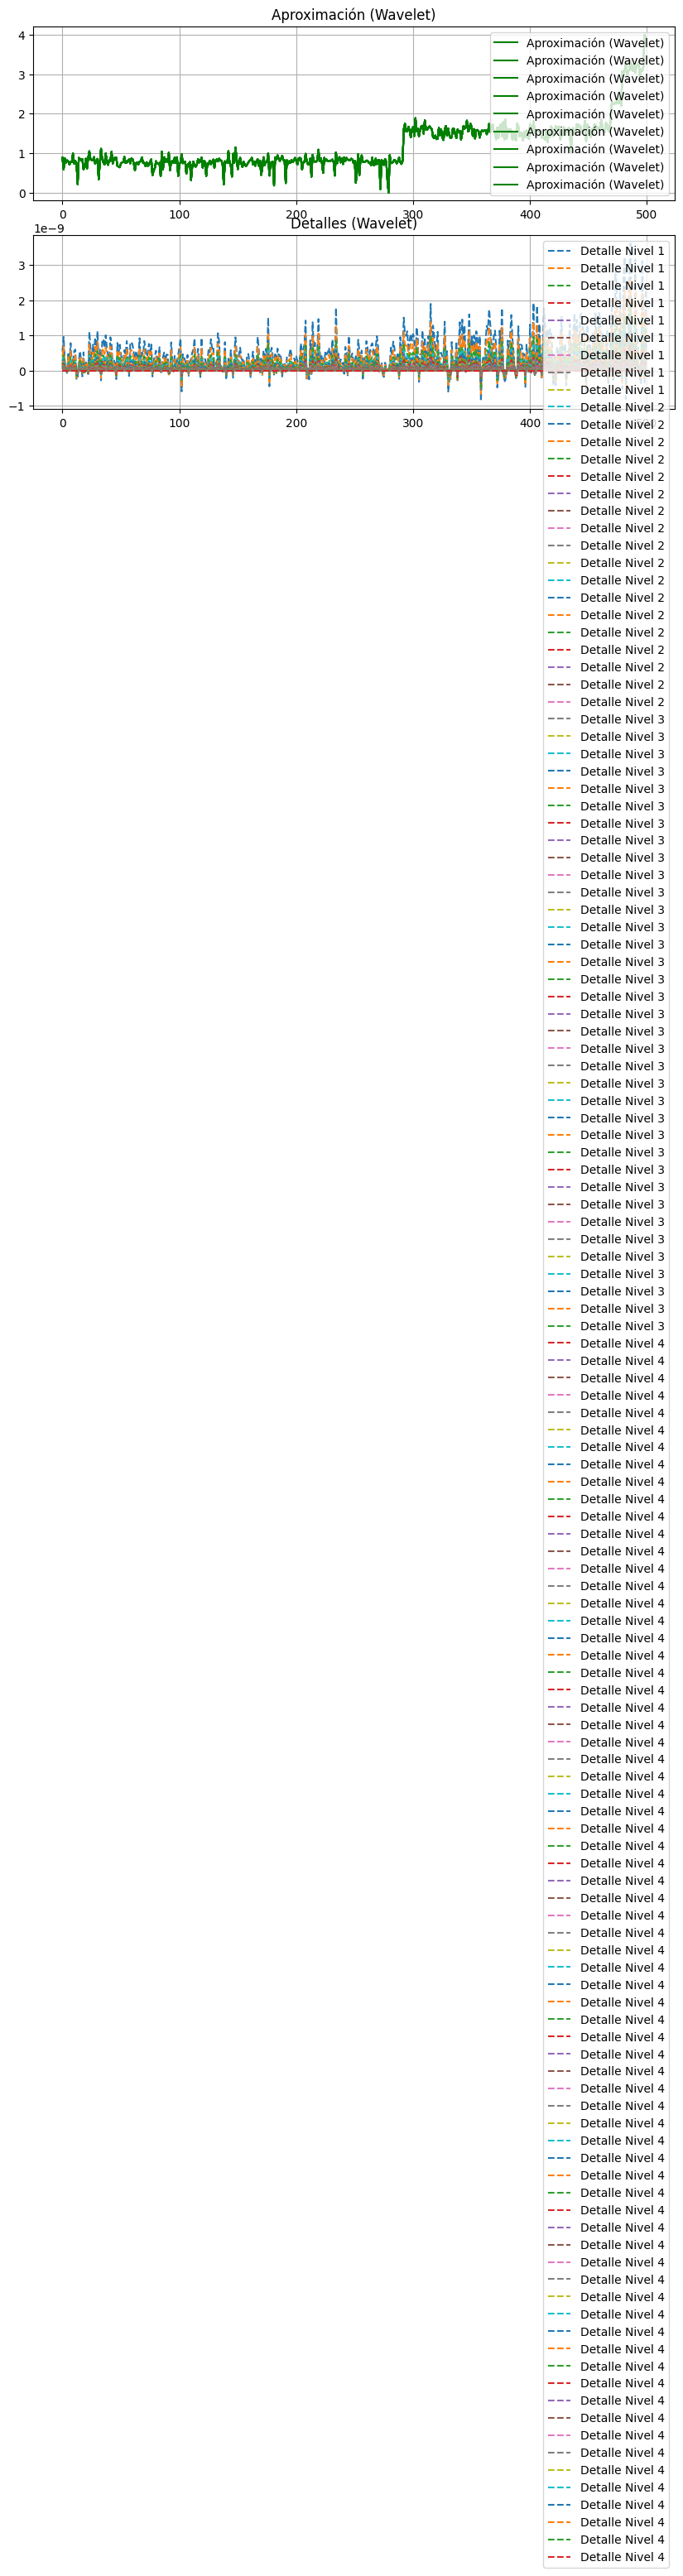

Epoch 1/50
4407/4407 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.0038
Epoch 2/50
4407/4407 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 1.1272e-07
Epoch 3/50
4407/4407 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 8.2312e-07
Epoch 4/50
4407/4407 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 4.9787e-07
Epoch 5/50
4407/4407 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 3.2376e-07
Epoch 6/50
4407/4407 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 4.1678e-07
Epoch 7/50
4407/4407 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 4.0660e-07
Epoch 8/50
4407/4407 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 2.7068e-07
Epoch 9/50
4407/4407 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 3.1568e-07
Epoch 10/50
4407/4407 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 3.0124e-07
Epoch 11/50
4407/4407 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 1.7234e-07
Epoch 12/50
4407/4407 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 2.5435e-07
Epoch 13/50
4407/4407 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 3.3963e-07
Epoch 14/50
4407/4407 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/s

ValueError: operands could not be broadcast together with shapes (70500,1) (500,1) 

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from pywt import wavedec
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Cargar los datos desde un archivo .txt
ecg_signal = np.loadtxt('../data/ECG5000_TRAIN.txt')  # El archivo tiene los datos separados por espacios

# Creamos un array de tiempo (suponiendo que los datos están a una frecuencia de 1000 Hz)
time = np.linspace(0, len(ecg_signal) / 1000, len(ecg_signal))  # Tiempo en segundos, ajusta según tu frecuencia de muestreo

# Filtro pasabajas para suavizar la señal
filtro_pasabajas = butter(4, 0.2, btype="low", fs=1000)  # Orden 4, frecuencia de corte 0.2 Hz
ecg_filtrada = filtfilt(filtro_pasabajas[0], filtro_pasabajas[1], ecg_signal)

def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

ecg_normalizada = normalize(ecg_filtrada)

# Transformada wavelet discreta (Haar)
coeffs = wavedec(ecg_normalizada, wavelet='haar', level=4)

# Separar la aproximación y los detalles
approximation = coeffs[0]  # Coeficiente de aproximación
details = coeffs[1:]  # Detalles a diferentes niveles

# Visualización de la aproximación y detalles
plt.figure(figsize=(10, 6))

# Aproximación
plt.subplot(2, 1, 1)
plt.plot(approximation, label="Aproximación (Wavelet)", color="green")
plt.legend()
plt.title("Aproximación (Wavelet)")
plt.grid()

# Detalles
plt.subplot(2, 1, 2)
for i, detail in enumerate(details):
    plt.plot(detail, label=f"Detalle Nivel {i+1}", linestyle='--')
plt.legend()
plt.title("Detalles (Wavelet)")
plt.grid()

plt.tight_layout()
plt.show()

# Reestructuramos la señal normalizada para entrenar el modelo (usamos la señal como entrada)
X_train = np.reshape(ecg_normalizada, (-1, 1))


# Definir el modelo autoencoder
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(X_train.shape[1], activation='linear')
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history = model.fit(X_train, X_train, epochs=50, batch_size=16)

# Paso 6: Predicción (reconstrucción de la señal)
reconstructed = reconstructed[:len(ecg_signal)]

# Paso 7: Calcular el error de reconstrucción
error = np.mean((X_train - reconstructed) ** 2, axis=1)

# Paso 8: Detectar anomalías (basado en el umbral de error)
threshold = np.mean(error) + 2 * np.std(error)
anomalies = np.where(error > threshold)[0]

# Visualizar los resultados
plt.figure(figsize=(10, 6))
plt.plot(time, ecg_signal, label="ECG Original", color="red")
plt.plot(time, ecg_filtrada, label="ECG Filtrada", color="blue")
plt.plot(time, reconstructed.flatten(), label="ECG Reconstruida", color="green")
plt.scatter(time[anomalies], ecg_signal[anomalies], color='black', label='Anomalías', zorder=5)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()
plt.title('Detección de Anomalías en Señales ECG')
plt.grid(True)
plt.show()

# Guardar pesos del modelo
model.save_weights("autoencoder.weights.h5")
print("Pesos del modelo guardados como 'autoencoder_weights.h5'")
